# DATA PIPELINE TO PREDICT OUTPUT FOR AN IMAGE OR SET OF IMAGES:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import keras

Using TensorFlow backend.


In [18]:
# !pip install git+https://github.com/qubvel/segmentation_models
# !pip install keras==2.3.1
# from efficientnet.tfkeras import EfficientNetB4

In [2]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [13]:
# function to covert Run-Length-Encoded Values to masks
# reference: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

def rle2mask(mask_rle, shape=(1600,256)):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

# Reference: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_1 = precision(y_true, y_pred)
    recall_1 = recall(y_true, y_pred)
    return 2*((precision_1*recall_1)/(precision_1+recall_1+K.epsilon()))

# Reference : https://stackoverflow.com/questions/59054564/dice-coefficient-above-1

def dice_coefficient(y_true, y_pred):
    
    y = K.flatten(y_true)
    y_predicted = K.flatten(y_pred)
    intersection = K.sum(y * y_predicted)
    
    return (2 * intersection + K.epsilon()) / (K.sum(y) + K.sum(y_predicted) + K.epsilon())

# reference: https://www.kaggle.com/stainsby/fast-tested-rle

def rle_encode(img):
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [46]:
def final_fun_1(X):
    
    root_path_test = '/content/drive/MyDrive/Case_Study_2/test_images/'

    # Loading All Best Models

    Best_Model_Binary = load_model('/content/drive/My Drive/Case_Study_2/Binary_models/Binary_model_Xception.h5',custom_objects = {'recall':recall,'precision':precision,'f1_score':f1_score})
    Best_Model_Binary.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

    Best_Model_Multi_Label = load_model('/content/drive/My Drive/Case_Study_2/Multi_Label_models/Multi_Label_model_InceptionResNetV2.h5',custom_objects = {'recall':recall,'precision':precision,'f1_score':f1_score})
    Best_Model_Multi_Label.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

    Best_Model_Segmentaion_C1 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class1.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
    Best_Model_Segmentaion_C1.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

    Best_Model_Segmentaion_C2 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class2.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
    Best_Model_Segmentaion_C2.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

    Best_Model_Segmentaion_C3 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class3.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
    Best_Model_Segmentaion_C3.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

    Best_Model_Segmentaion_C4 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class4.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
    Best_Model_Segmentaion_C4.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

    
    for i in list(X.index):
      
      plt.figure(figsize=(21,5))
      
      # Binary & Multi Label model
      
      image = cv2.imread(root_path_test + X['Id'][i], cv2.IMREAD_UNCHANGED)
      image = cv2.resize(image, (299,299), interpolation=cv2.INTER_NEAREST)
      image = (1/255.)*image

      if Best_Model_Binary.predict(image[np.newaxis,:,:,:])[0][0] > 0.9:
        class_probs = Best_Model_Multi_Label.predict(image[np.newaxis,:,:,:])[0]
        image = cv2.imread(root_path_test + X['Id'][i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256,800), interpolation=cv2.INTER_NEAREST)
        image = (1/255.)*image
        
        
        if class_probs[0] > 0.5:
          predicted  = Best_Model_Segmentaion_C1.predict(image[np.newaxis,:,:,:])
          predicted = predicted[0,:,:,0]
          predicted = predicted.T

          plt.subplot(141)
          plt.imshow(predicted)
          plt.title("Predicted Mask For Class_1" + " ID " + str(i) + ':')
          plt.show()
        
        if class_probs[1] > 0.5:
          predicted  = Best_Model_Segmentaion_C2.predict(image[np.newaxis,:,:,:])
          predicted = predicted[0,:,:,0]
          predicted = predicted.T
               
          plt.subplot(142)
          plt.imshow(predicted)
          plt.title("Predicted Mask For Class_2" + " ID " + str(i) + ':')
          plt.show()
        
        if class_probs[2] > 0.5:
          predicted  = Best_Model_Segmentaion_C3.predict(image[np.newaxis,:,:,:])
          predicted = predicted[0,:,:,0]
          predicted = predicted.T
          
          plt.subplot(143)
          plt.imshow(predicted)
          plt.title("Predicted Mask For Class_3" + " ID " + str(i) + ':')
          plt.show()
        
        if class_probs[3] > 0.5:
          predicted  = Best_Model_Segmentaion_C4.predict(image[np.newaxis,:,:,:])
          predicted = predicted[0,:,:,0]
          predicted = predicted.T
          
          plt.subplot(144)
          plt.imshow(predicted)
          plt.title("Predicted Mask For Class_4" + " ID " + str(i) + ':')
          plt.show()
        
        elif (class_probs[0]<=0.5) and (class_probs[1]<=0.5) and (class_probs[2]<=0.5) and (class_probs[3]<=0.5):
          class_ = np.argmax(class_probs) + 1

          if class_ == 1:
            predicted  = Best_Model_Segmentaion_C1.predict(image[np.newaxis,:,:,:])
            predicted = predicted[0,:,:,0]
            predicted = predicted.T
            
            plt.subplot(141)
            plt.imshow(predicted)
            plt.title("Predicted Mask For Class_1" + " ID " + str(i) + ':')
            plt.show() 
          
          elif class_==2:
            predicted  = Best_Model_Segmentaion_C2.predict(image[np.newaxis,:,:,:])
            predicted = predicted[0,:,:,0]
            predicted = predicted.T
            
            plt.subplot(142)
            plt.imshow(predicted)
            plt.title("Predicted Mask For Class_2" + " ID " + str(i) + ':')
            plt.show() 
          
          elif class_==3:
            predicted  = Best_Model_Segmentaion_C3.predict(image[np.newaxis,:,:,:])
            predicted = predicted[0,:,:,0]
            predicted = predicted.T
            
            plt.subplot(143)
            plt.imshow(predicted)
            plt.title("Predicted Mask For Class_3" + " ID " + str(i) + ':')
            plt.show() 
          
          elif class_==4:
            predicted  = Best_Model_Segmentaion_C4.predict(image[np.newaxis,:,:,:])
            predicted = predicted[0,:,:,0]
            predicted = predicted.T
            
            plt.subplot(144)
            plt.imshow(predicted)
            plt.title("Predicted Mask For Class_4" + " ID " + str(i) + ':')
            plt.show() 
        
      else:
        print("ID " + str(i) + ':' + ' The Given image Have No Defect')
    

## PREDICTIONS ON A SAMPLE TEST DATA ( SINGLE OR MULTI INPUT ):

In [15]:
root_path_test = '/content/drive/MyDrive/Case_Study_2/test_images/'
Test_image_names = []
for i in os.listdir(root_path_test):
    Test_image_names.append(i)

test_df = pd.DataFrame(Test_image_names,columns=['Id'])
test_df.head(10)

,Id
0,db72ffc2e.jpg
1,d221d2a3f.jpg
2,d20453181.jpg
3,d670249ed.jpg
4,d5e8bbe9a.jpg
5,d8451253a.jpg
6,d7cc00da8.jpg
7,d72ec3680.jpg
8,d2033d01e.jpg
9,d118e5d28.jpg


In [43]:
# reference : https://www.geeksforgeeks.org/python-get-a-list-as-input-from-user/

lst = [] 
n = int(input("NUMBER OF THE DATAPOINTS TO BE PREDICTED: ")) 
if n >1: 
    print("Enter the ids of the" + str(n)+' data points')
else:
    print("Enter the id of the point")
for i in range(0, n): 
    ele = int(input())
    lst.append(ele) 
      
print(lst) 

NUMBER OF THE DATAPOINTS TO BE PREDICTED: 8
Enter the ids of the8 data points
44
3
420
800
1658
2999
300
250
[44, 3, 420, 800, 1658, 2999, 300, 250]


In [44]:
X_test =test_df.loc[lst]
X_test

,Id
44,d5bbdc8a8.jpg
3,d670249ed.jpg
420,df62d5dac.jpg
800,fb6e8874b.jpg
1658,c4987c901.jpg
2999,99ac0a458.jpg
300,e0a5a7636.jpg
250,dcdfc29b2.jpg


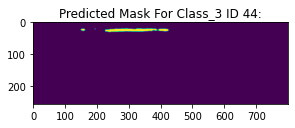

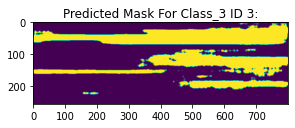

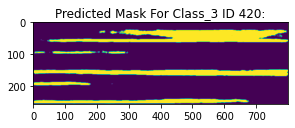

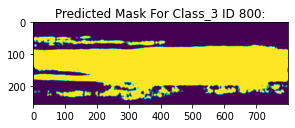

ID 1658: The Given image Have No Defect


<Figure size 1512x360 with 0 Axes>

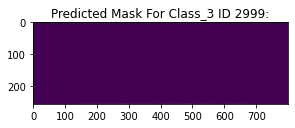

ID 300: The Given image Have No Defect
ID 250: The Given image Have No Defect


<Figure size 1512x360 with 0 Axes>

<Figure size 1512x360 with 0 Axes>

In [47]:
final_fun_1(X_test)